In [1]:
!pip install tsaug

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from Data_Augmentation.vpower_src.utils.auxiliary_functions import *

from tsaug.visualization import plot as tsaug_plot
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse


In [3]:
torch.cuda.is_available()

True

In [4]:
data_dir_r =  "../../Data/split_quad"

In [5]:
data_all = {}

for partition in ["train", "test", "val", "lourd"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="index")
    data_all[partition+"_r"] = df

data_all["train"]=data_all["train_r"]
data_all["test"]=data_all["test_r"]

In [6]:
input_features = [
    #time_start,
    "flight",
    "time",
    "wind_speed",
    "wind_angle",
    #battery_voltage,
    #battery_current,
    #position_x,
    #position_y,
    "position_z",
    "orientation_x",
    "orientation_y",
    "orientation_z",
    "orientation_w",
    "velocity_x",
    "velocity_y",
    "velocity_z",
    "angular_x",
    "angular_y",
    "angular_z",
    "linear_acceleration_x",
    "linear_acceleration_y",
    "linear_acceleration_z",
    #speed,
    #payload,
    #altitude,
    #route,
    #power,
    "power_smoothed"
]


In [7]:
data_all_features = {}
data_all_features["train"] = pd.DataFrame(data_all["train"][input_features])
data_all_features["test"] = pd.DataFrame(data_all["test"][input_features])

In [8]:
data_all_features["train"]

,flight,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_y,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,power_smoothed
index,,,,,,,,,,,,,,,,,,,
112,1,0.00,1.4,37.0,270.407091,0.001720,0.006205,-0.253333,0.967358,-0.002432,-0.003165,0.012458,0.007095,0.007995,-0.000479,0.033248,-0.114812,-9.824341,9.420778
113,1,0.21,1.4,36.0,270.432353,0.001805,0.006146,-0.253320,0.967361,-0.005957,-0.005853,0.014279,0.023892,-0.001515,0.011397,0.042173,-0.108319,-9.837841,144.741104
114,1,0.31,1.4,42.0,270.433609,0.001692,0.006400,-0.253269,0.967373,-0.017549,-0.008293,0.011364,-0.058678,0.020939,0.017794,0.005411,-0.188141,-9.812851,24.731003
115,1,0.50,1.4,42.0,270.459037,0.001717,0.006165,-0.253344,0.967355,-0.010196,-0.003564,0.011466,0.000014,-0.005369,-0.005043,0.034055,-0.114786,-9.808225,6.732263
116,1,0.61,1.3,41.0,270.460150,0.001703,0.006054,-0.253208,0.967391,-0.009259,-0.008219,0.011488,0.000341,0.005684,-0.012929,0.008335,-0.094107,-9.812603,9.426145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257751,279,115.30,2.4,187.0,270.101902,0.020128,0.021496,0.012031,0.999494,0.046611,0.040642,-0.063741,0.018590,0.000463,-0.013168,0.495337,-0.423297,-9.763877,65.828233
257752,279,115.50,2.5,187.0,270.121009,0.020270,0.020464,0.011903,0.999514,0.036736,0.027911,-0.059044,-0.030491,0.007425,-0.000605,0.381390,-0.399418,-9.740478,47.635991
257757,279,116.30,2.6,180.0,270.168574,0.020504,0.017502,0.011056,0.999575,0.030060,0.033653,-0.037571,-0.042004,0.011623,0.044291,0.421674,-0.361034,-9.817332,82.214738


# Pipeline of augmenters

In [9]:
my_augmenter = (
    TimeWarp() * 5  # random time warping 5 times in parallel
    + Crop(size=300)  # random crop subsequences with length 300
    + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
    + Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
    + Reverse() @ 0.5  # with 50% probability, reverse the sequence
)

In [10]:
df = data_all_features["train"]

flight_data_list = []

for n, g in df.groupby('flight'): # n = num vol, g = data all n, one by one
    flight_data_list.append(g)

min_length = min(len(f) for f in flight_data_list)

for i, f in enumerate(flight_data_list):
    flight_data_list[i] = f[:min_length]

numpy_array = np.array(flight_data_list)

numpy_array.shape

(195, 450, 19)

In [14]:
x = my_augmenter.augment(numpy_array)
x.shape
#tsaug_plot(x)

(975, 300, 19)

(<Figure size 1152x1440 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

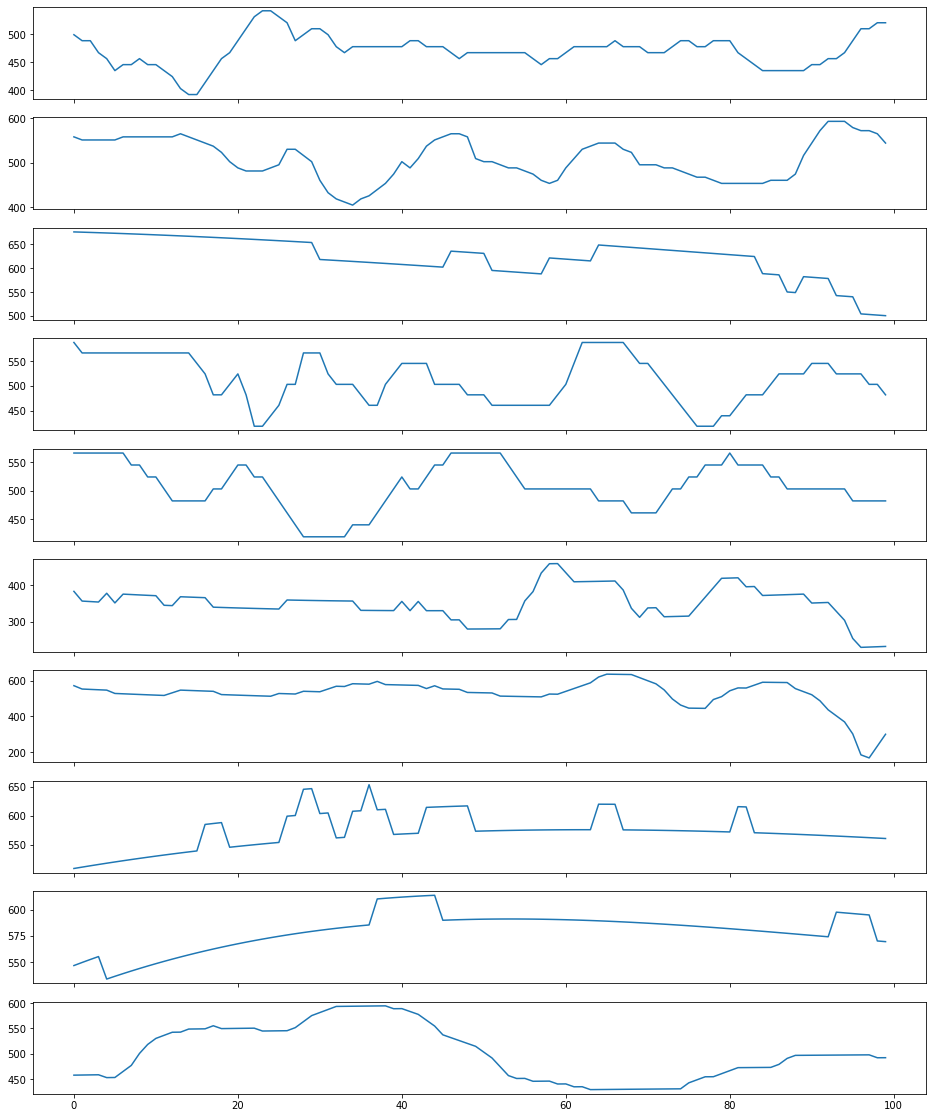

In [15]:
tsaug_plot(x[:10, :100, 18])

(<Figure size 1152x1440 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

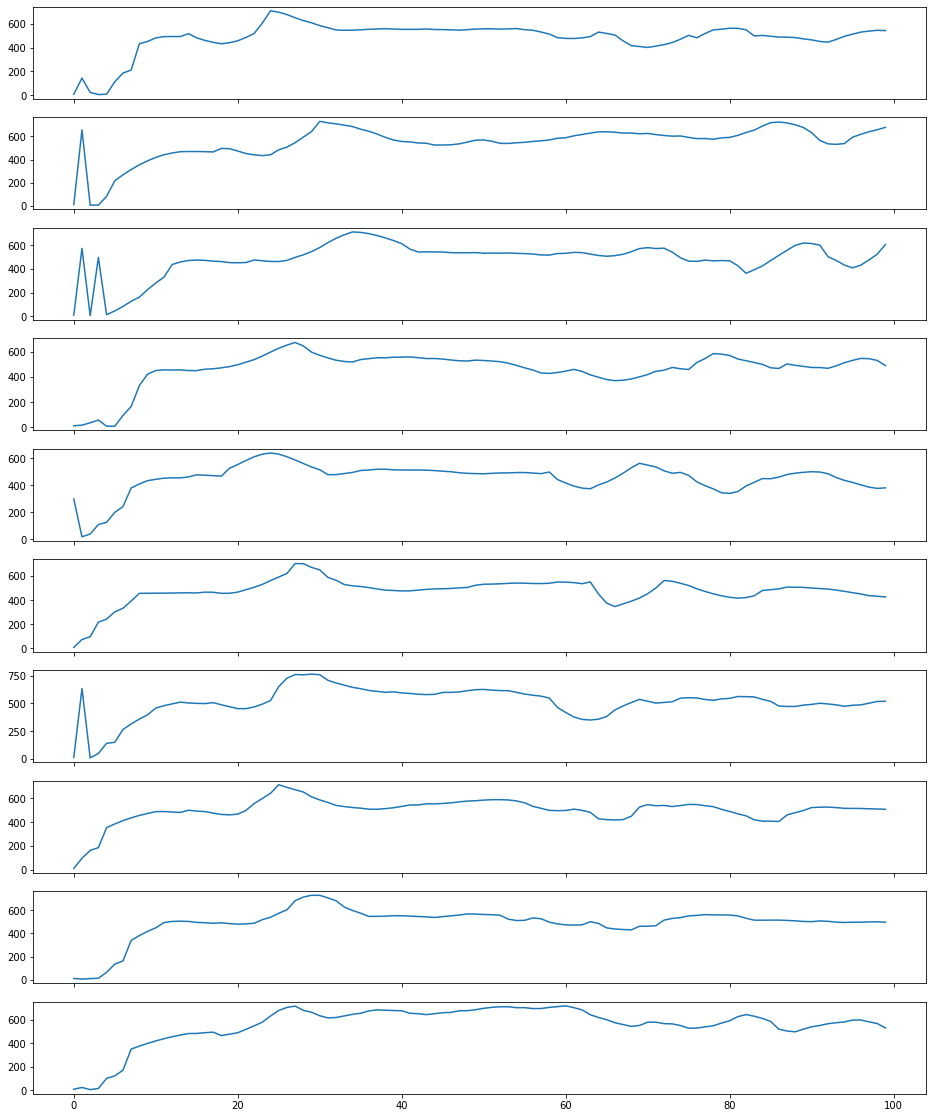

In [13]:
tsaug_plot(numpy_array[:10, :100, 18])